# Analyse Gap Rate in called IBD

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import h5py
import matplotlib.cm as cm
import itertools as it
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("bionc") or socket_name.startswith("hpc"):
    print("Leipzig Cluster detected!")
    path = "/mnt/archgen/users/hringbauer/"
    #sys.path.append("/mnt/archgen/users/hringbauer/git/hapBLOCK/python3/")
    #sys.path.insert(0, "/mnt/archgen/users/hringbauer/git/hapBLOCK/package/")
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

from ancIBD.ibd_stats.funcs import new_columns
from ancIBD.plot.plot_df import plot_scatter_ibd
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

hpc030
Leipzig Cluster detected!
/mnt/archgen/users/hringbauer
CPU Count: 128


In [2]:
v0 = "10.0" # The IBD version Number
meta_v = "0.14" # Pandora Meta Version
folder_out = f"/mnt/archgen/ibd_release/v{v0}/"

#df_meta = pd.read_csv(f"{folder_out}iid.ibd.meta.v{v0}.tsv",  sep="\t")
df_meta = pd.read_csv(f"/mnt/archgen/ibd_release/v{v0}/iid.ibd.meta.v{v0}_AADR.tsv", sep="\t")

print(f"Loaded {len(df_meta)} IIDs from IBD run with meta info.")

df_ibds = pd.read_csv(f"{folder_out}ibd220f.ind.{v0}.tsv",  sep="\t") #f: Filtered Version
print(f"Loaded {len(df_ibds)} IID pairs")

df1 = pd.read_csv(f"./git/auto_popgen/data/meta/pandora_meta.v{meta_v}.tsv", sep="\t") #
df1 = df1.rename(columns={"Full_Individual_Id":"iid"})

df_ibds = new_columns(df_ibds, df_meta, col=["frac_gp", "Locality"]) # "Locality", "Province", "C14_mean", "imputation_type"
df_ibds = new_columns(df_ibds, df1, col=["Country", "date", "date_type"]) # "Locality", "Province", "C14_mean", 

x = 0.7
df_ibds2 = df_ibds[(df_ibds["frac_gp1"]>x) & (df_ibds["frac_gp2"]>x)]
print(f"Loaded {len(df_ibds2)} IID pairs with GP_max frac > {x}")

Loaded 17474 IIDs from IBD run with meta info.
Loaded 2684964 IID pairs
Loaded 943070 IID pairs with GP_max frac > 0.7


### Load all Parent-Offspring

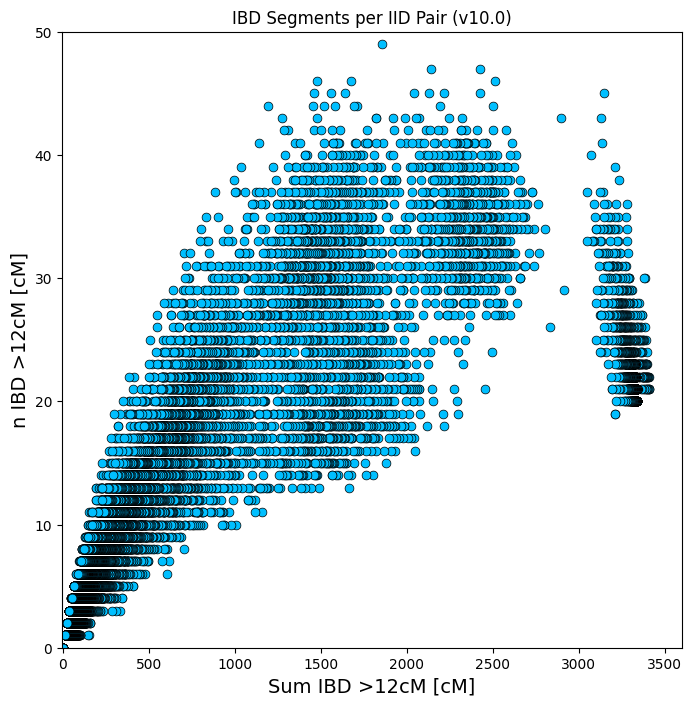

In [3]:
plot_scatter_ibd(df_ibds2, title=f"IBD Segments per IID Pair (v{v0})", savepath="")

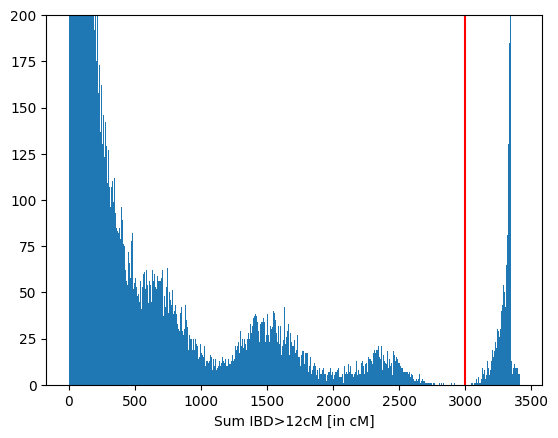

In [6]:
plt.figure()
ax=plt.gca()
ax.hist(df_ibds2["sum_IBD>12"], ec="k",bins=500)
ax.set_ylim([0,200])
ax.axvline(3000, c="red")
ax.set_xlabel("Sum IBD>12cM [in cM]")
plt.show()

In [7]:
cutoff=3000
df_po = df_ibds2[df_ibds2["sum_IBD>12"]>cutoff]
print(f"Found {len(df_po)} Parent-Offspring")

Found 1679 Parent-Offspring


### Extract the number of IBD Segments for each Chromosome

In [8]:
df_ibd = pd.read_csv(f"/mnt/archgen/ibd_release/v{v0}/ibd220f.ibd.{v0}.tsv", sep="\t")
print(f"Loaded n={len(df_ibd)} IBD segments")

Loaded n=3647101 IBD segments


### Subset to IBD segments in Parent Offspring

In [9]:
### Subset to IBD segments in parent offspring
pair_iids = df_ibd["iid1"] + "___" + df_ibd["iid2"]
po_iids1 = df_po["iid1"] + "___" + df_po["iid2"]
po_iids2 = df_po["iid2"] + "___" + df_po["iid1"]
idx_po = pair_iids.isin(po_iids1) | pair_iids.isin(po_iids2)
df_ibd_po = df_ibd[idx_po]

### Create the Chromosome Count
df_n_ch = pd.DataFrame(df_ibd_po["ch"].value_counts())
df_n_ch = df_n_ch.reset_index()

In [10]:
df_n_ch

,ch,count
0,1,2247
1,2,2091
2,6,2054
3,9,1958
4,3,1956
5,4,1952
6,5,1939
7,8,1938
8,7,1915
9,11,1910


### Plot IBD rate per chromosome

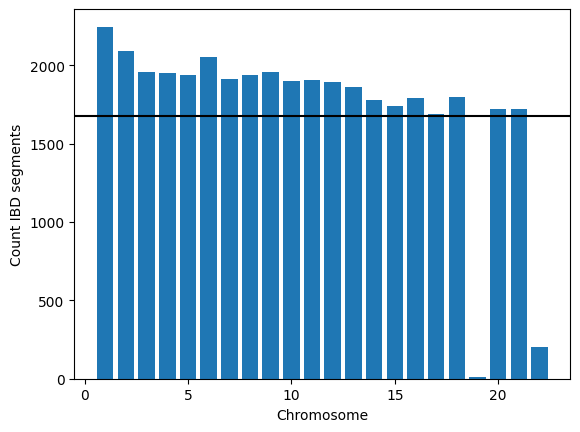

In [12]:
plt.figure()
ax = plt.gca()

ax.bar( df_n_ch["ch"], df_n_ch["count"])

ax.axhline(len(df_po), c="k", label="# PO")

ax.set_xlabel("Chromosome")
ax.set_ylabel("Count IBD segments")

plt.show()

# Visualize completeness across genome
Show how many IBD segments of PO in each region

In [2]:
def load_map(path_h5, map_col="variants/MAP", verbosity=0):
    """Load map positions from hdf5"""
    f = h5py.File(path_h5, "r") # Load for Sanity Check. See below!
    m = f[map_col][:]
    if verbosity>0:
        print(f"Loaded {len(m)} map positions")
    return m


def create_counts_chs(df, bin_width=0.005, chs=range(1,23)):
    """Iterate over all chromosomes: Given a IBD dataframe and recombination map,
    produce a counts array counting how often each bin is hit.
    Return bin edges and counts in each bin.
    bin_width: Width of each bin [in Morgan]"""
    k = len(chs)

    bins10_chs = [[] for _ in chs]
    counts_chs = [[] for _ in chs]
    ms = [[] for _ in chs]
    
    for i, ch in enumerate(chs):
        m = load_map(f"/mnt/archgen/ibd_release/data/h5.master/v10.0/ch{ch}.h5")
        dft = df[df["ch"]==ch]
        bins10, counts = create_counts(dft, m, bin_width=bin_width)
        
        bins10_chs[i] = bins10
        counts_chs[i] = counts
        ms[i]=m

    return bins10_chs, counts_chs, ms

def create_start_end_counts_chs(df, bin_width=0.005, chs=range(1,23), 
                                path_h5=f"/mnt/archgen/ibd_release/data/h5.master/v10.0/ch"):
    """Iterate over all chromosomes: Given a IBD dataframe and recombination map,
    produce a counts array counting start and end positions of IBD segments
    Return bin edges [n] and start and end counts [n] in each bin. A list of each respective 
    output for each chromosome in chs
    bin_width: Width of each bin [in Morgan]"""
    k = len(chs)

    bins10_chs = [[] for _ in chs]
    counts_chs_start = [[] for _ in chs]
    counts_chs_end = [[] for _ in chs]
    ms = [[] for _ in chs]
    
    for i, ch in enumerate(chs):
        m = load_map(f"{path_h5}{ch}.h5")
        dft = df[df["ch"]==ch]
        bins10, counts = create_counts_start_end(dft, m, bin_width=bin_width)
        
        bins10_chs[i] = bins10
        counts_chs_start[i] = counts[:,0]
        counts_chs_end[i] = counts[:,1]
        ms[i]=m

    return bins10_chs, counts_chs_start, counts_chs_end, ms


def create_counts(df, m, bin_width=0.005):
    """Given a IBD dataframe and recombination map,
    produce a counts array counting how often each bin is hit.
    Return bin edges and counts in each bin.
    bin_width: Width of each bin [in Morgan]"""
    starts = df["StartM"].values
    ends = df["EndM"].values

    ### Create the Binned Statistic
    bins10 = np.arange(min(m), max(m), step=bin_width)  # 0.1 cM Bins
    counts = np.zeros(len(bins10), dtype="int")

    for i in range(len(starts)):
        i1 = np.searchsorted(bins10, starts[i])
        i2 = np.searchsorted(bins10, ends[i])
        counts[i1:i2] = counts[i1:i2]+1 # Add one to the counter
    return bins10, counts

def create_counts_start_end(df, m, bin_width=0.005):
    """Given a IBD dataframe and recombination map,
    produce a counts array counting how often each bin is hit by start and end.
    Return bin edges [n array] and start and end counts in each bin [n,2] array.
    bin_width: Width of each bin [in Morgan]"""

    ### Create the Binned Statistic
    bins10 = np.arange(min(m), max(m), step=bin_width)  # 0.1 cM Bins
    bins10 = np.append(bins10, bins10[-1]+bin_width) # Add one bin to have end in for sure
    counts = np.zeros((len(bins10),2), dtype="int")

    starts = df["StartM"].values 
    ends = df["EndM"].values
    i1 = np.searchsorted(bins10, starts)
    i2 = np.searchsorted(bins10, ends)
    for i in i1:
        counts[i,0] = counts[i,0]+1 # Add one to the start counter
    for i in i2:
        counts[i,1] = counts[i,1]+1 # Add one to the end counter
        
    return bins10, counts


### The plotting function

def plot_ch_po_rate(bins_M, counts, counts_end=[], m=[], figsize=(6,6), ylim=[], ch=0, n_po=1679,
                    c1="red", c2="blue", fs=12, lab_y="Count"):
    """Plotting Function to visualize counts and SNP density across chromosome."""

    lab_x = f"Morgan (Chr. {ch})"
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_xlim((bins_M[0], bins_M[-1]))
    ax.plot(bins_M, counts, color=c1)

    ### Plot Second count for comparison
    if len(counts_end)>0:
        ax.plot(bins_M, counts_end, color=c1, ls="--")
    
    ax.tick_params(axis='y', labelcolor=c1)
    if len(ylim)>0:
        ax.set_ylim(ylim)
    ax.set_ylabel(lab_y, fontsize=fs, color=c1)

    
    if len(ms)>0:
        ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        n, b = np.histogram(m, bins = bins_M)
        x = (b[1:] + b[:-1]) / 2
        ax1.plot(x, n, color=c2, linewidth=1.0)
        ax1.tick_params(axis='y', labelcolor=c2)
        #ax1.set_ylim(ylim)
        ax1.set_ylabel("NR SNPs per 0.5 cM", color=c2, rotation=270, labelpad=fs*1.4, fontsize=fs)
        ax.axhline(n_po, c="k", ls="--")
    
    ax.set_xlabel(lab_x, fontsize=fs)
    plt.show()

In [14]:
bins10_chs, counts_chs, ms = create_counts_chs(df_ibd_po)

Loaded 90793 map positions
Loaded 96120 map positions
Loaded 79135 map positions
Loaded 70117 map positions
Loaded 72256 map positions
Loaded 77293 map positions
Loaded 61188 map positions
Loaded 62644 map positions
Loaded 51749 map positions
Loaded 60018 map positions
Loaded 55956 map positions
Loaded 54944 map positions
Loaded 39765 map positions
Loaded 37030 map positions
Loaded 35110 map positions
Loaded 35349 map positions
Loaded 29849 map positions
Loaded 34621 map positions
Loaded 18857 map positions
Loaded 29670 map positions
Loaded 16379 map positions
Loaded 16139 map positions


In [16]:
ms[0]

array([0.02013 , 0.020242, 0.022137, ..., 2.862626, 2.862668, 2.86273 ],
      shape=(90793,), dtype=float32)

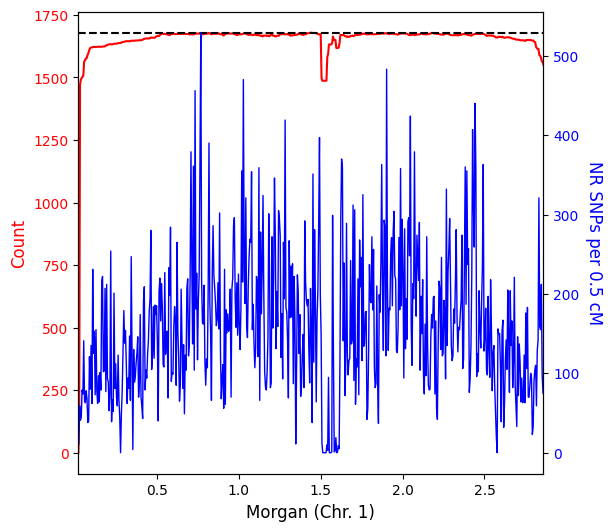

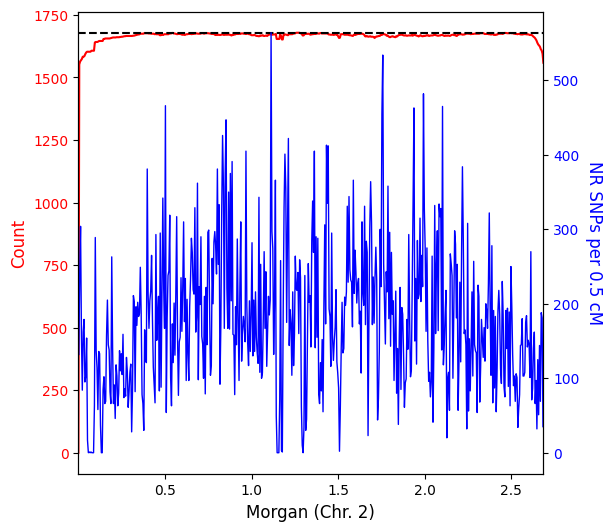

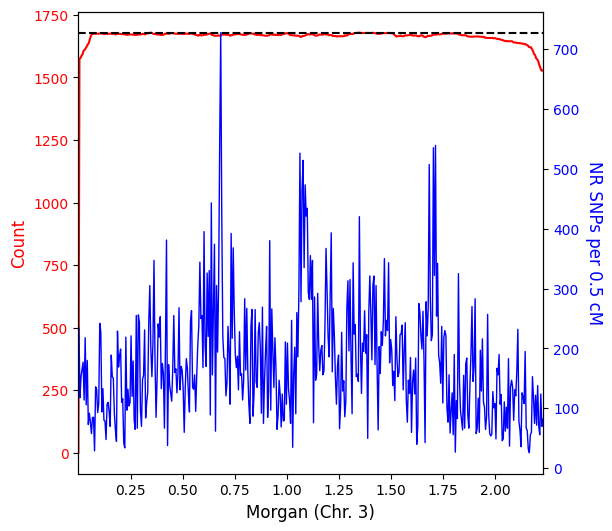

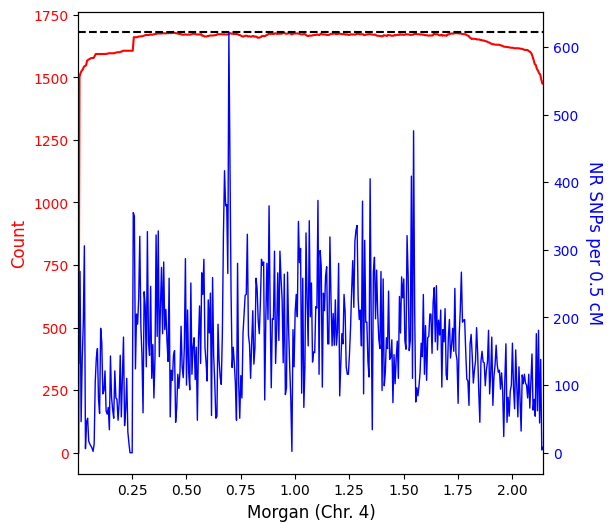

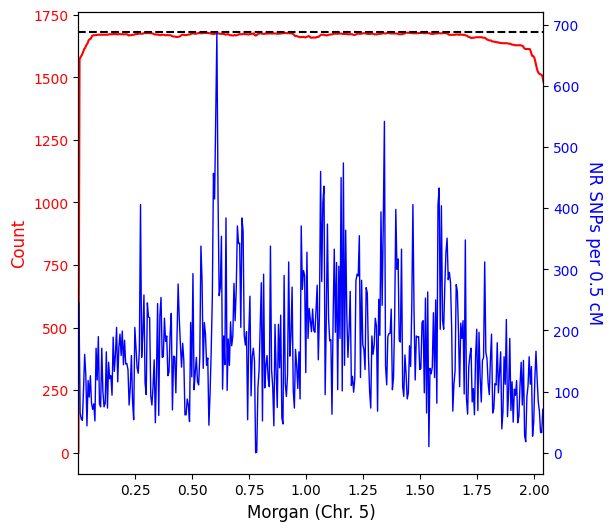

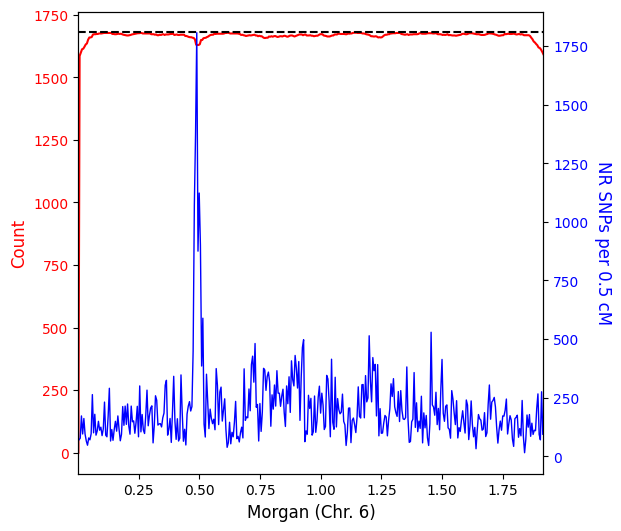

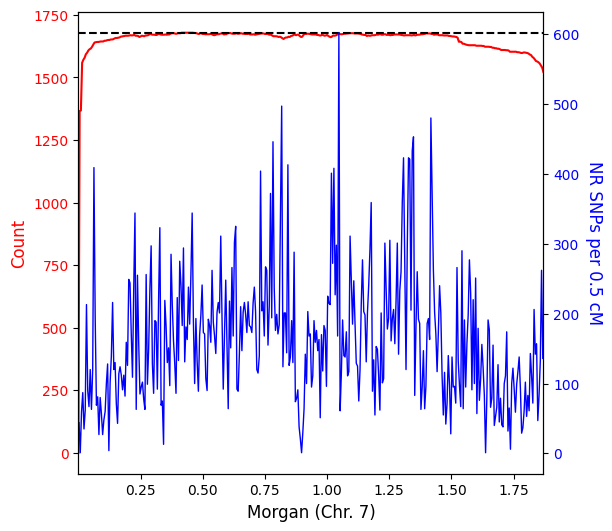

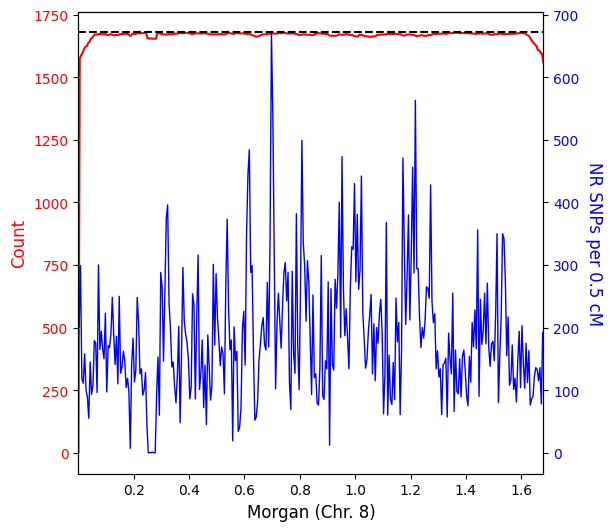

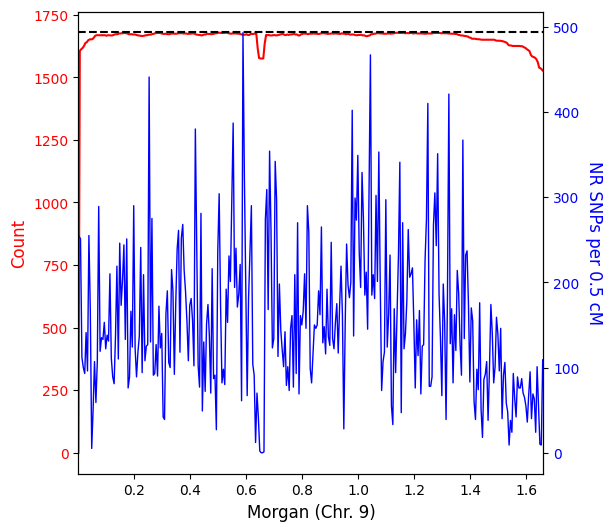

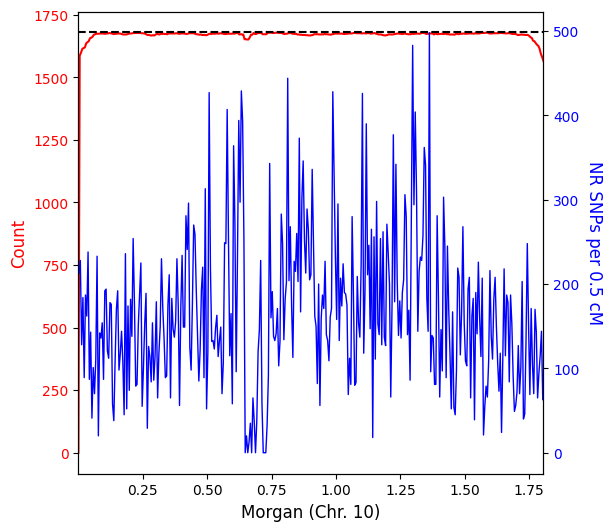

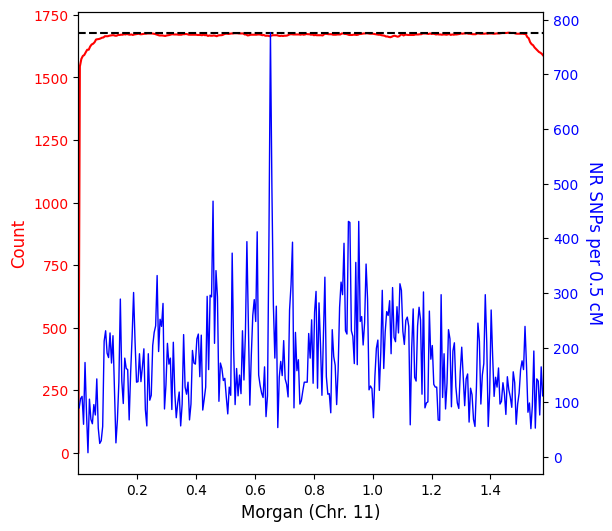

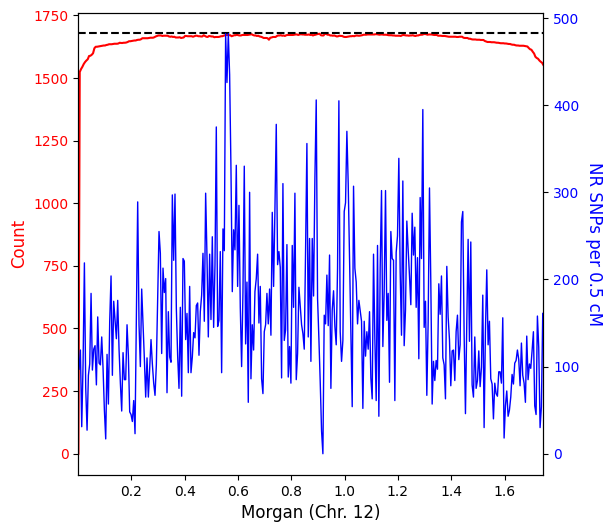

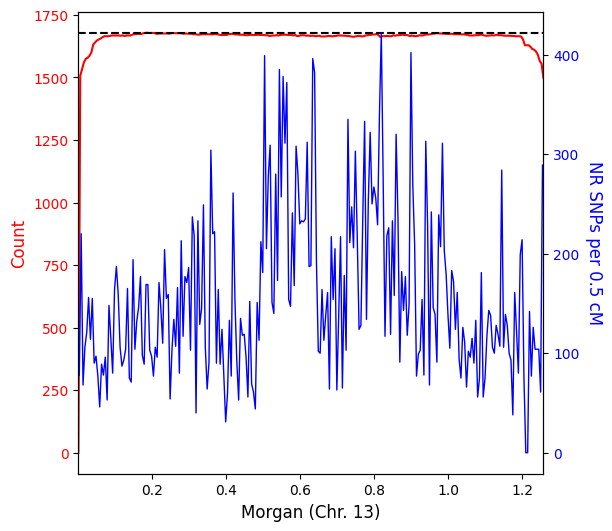

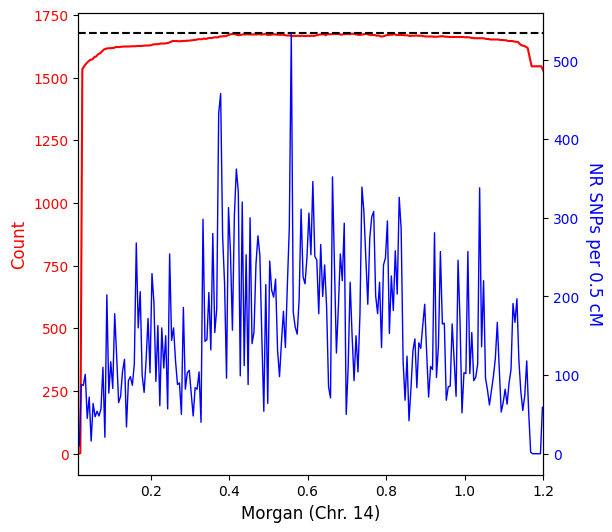

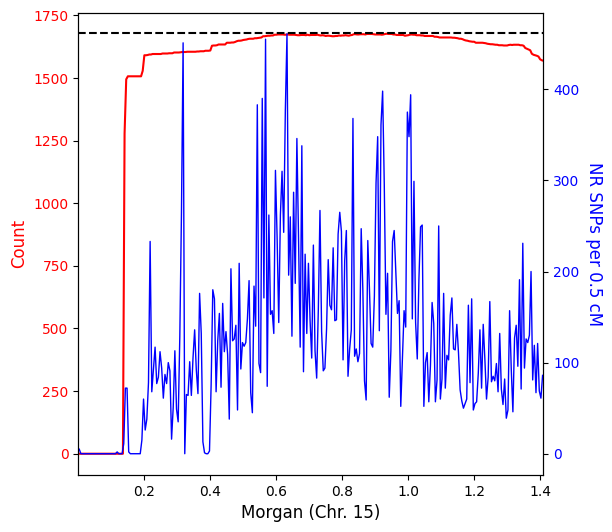

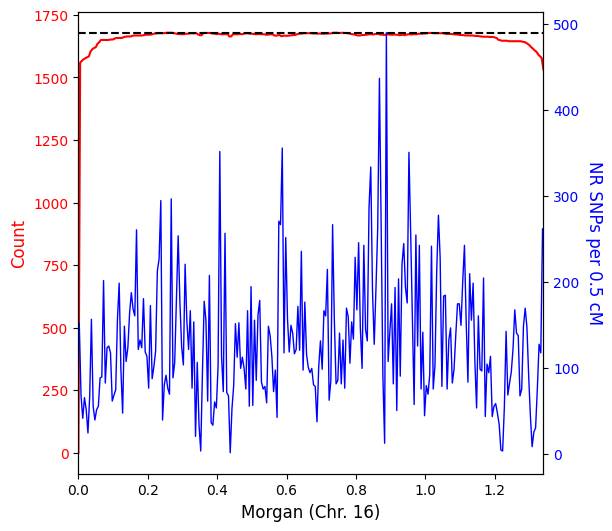

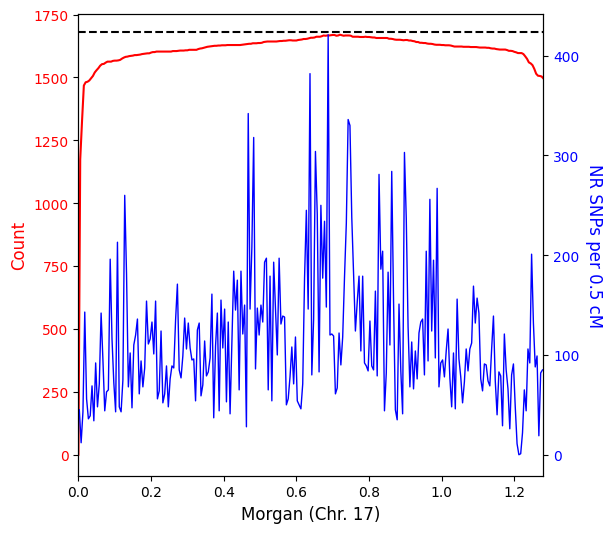

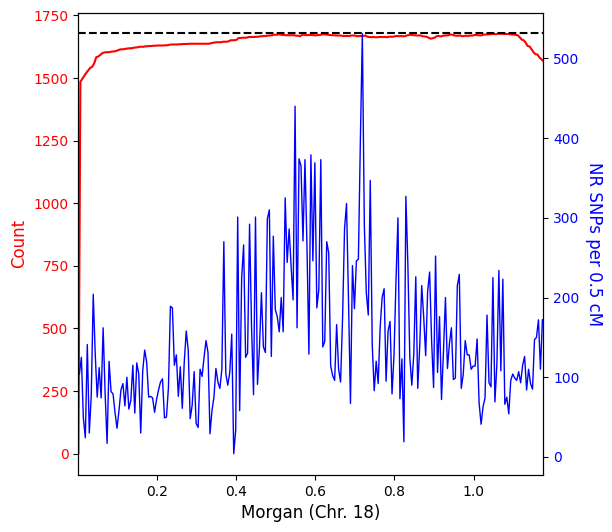

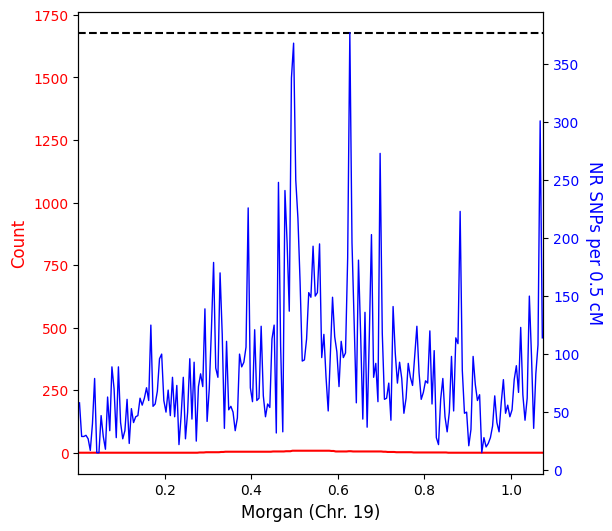

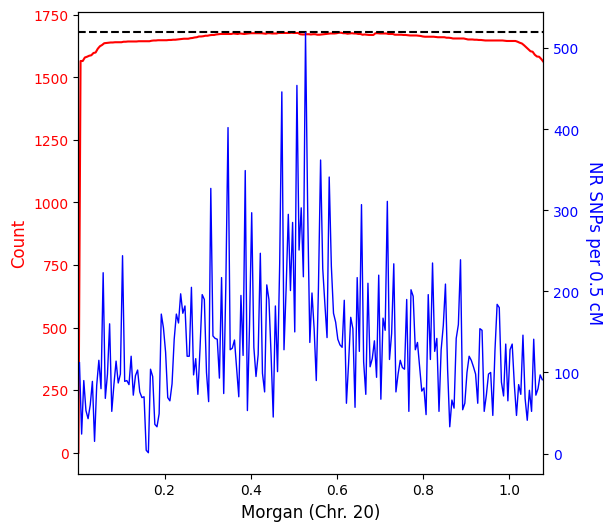

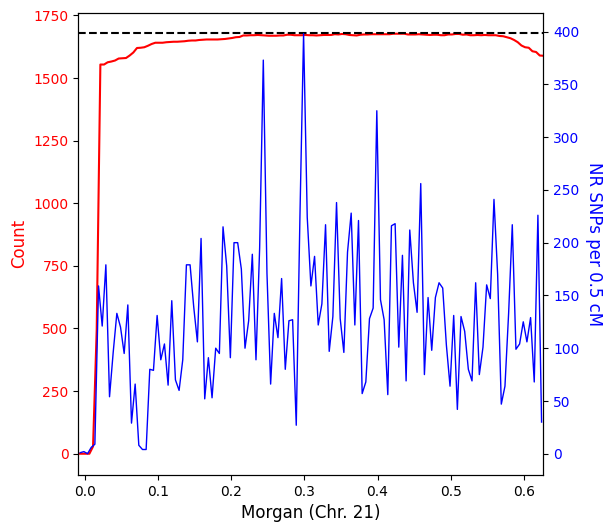

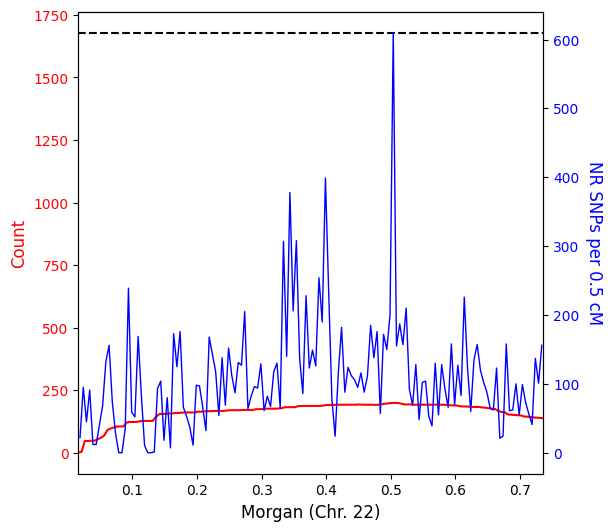

In [17]:
for ch in range(1,23):
    plot_ch_po_rate(bins10_chs[ch-1], counts=counts_chs[ch-1], m=ms[ch-1], ch=ch)

# 3) Analyze where the gaps in Parent-Offspring IBD are

In [12]:
bins10_chs, counts_chs_start, counts_chs_end, ms = create_start_end_counts_chs(df_ibd_po)

In [31]:
_, counts_chs, _ = create_counts_chs(df_ibd_po) # Load the number of IBDs covering each position 
### Required for normalization below. would give back same bins10_chs and ms as above (only last is padded above)
### Both use 0.5cM default for map bins

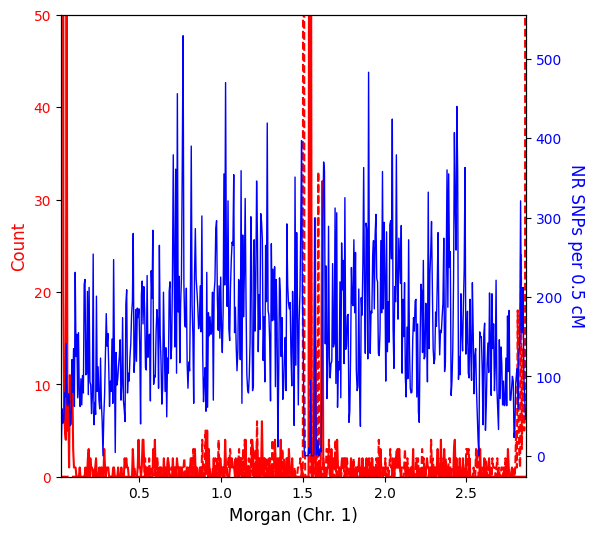

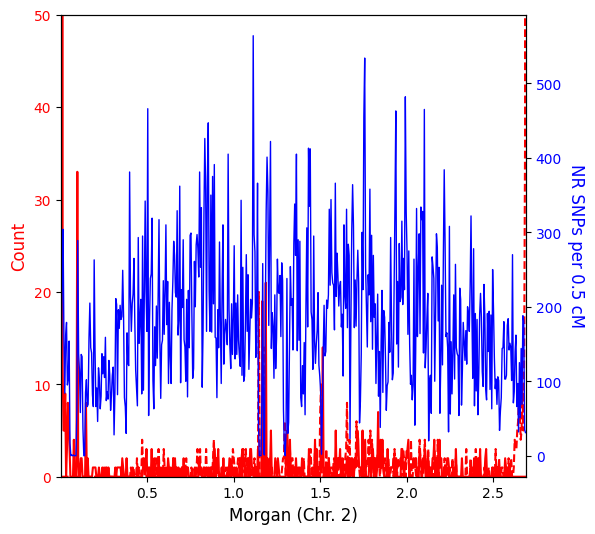

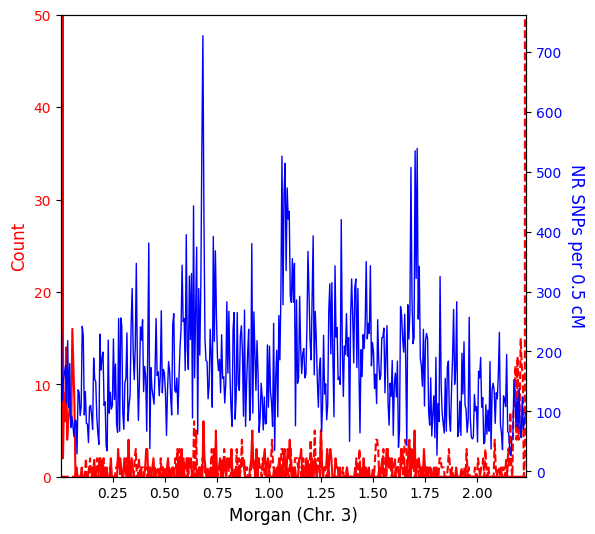

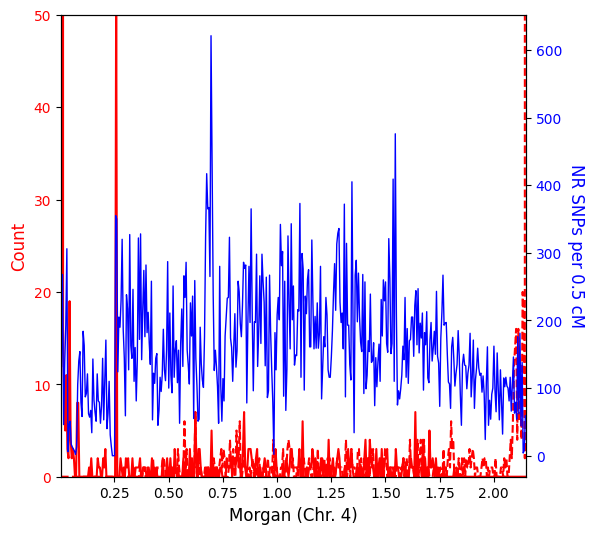

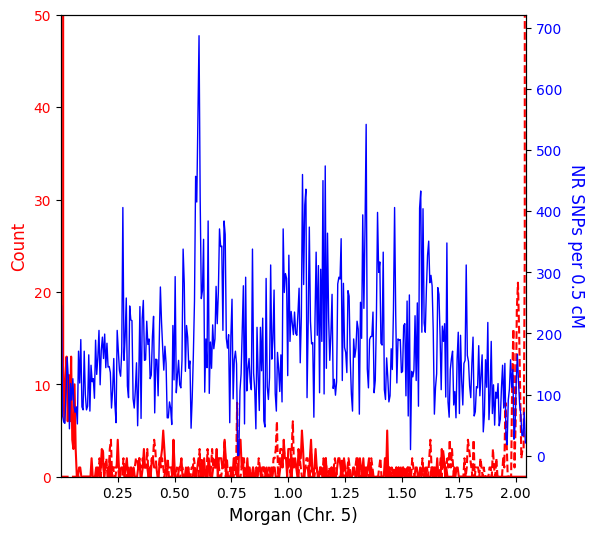

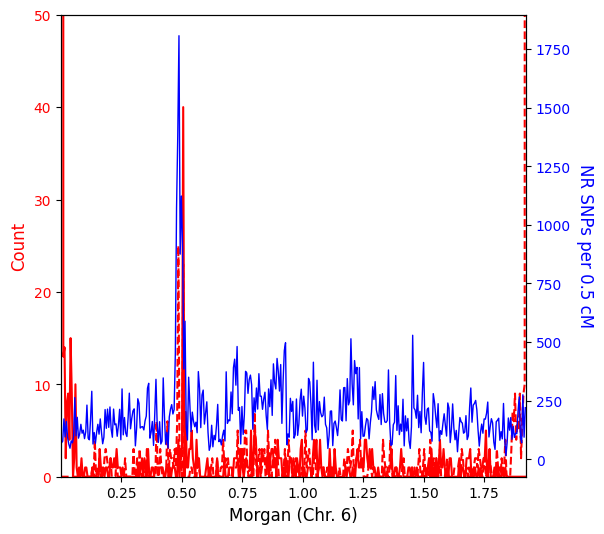

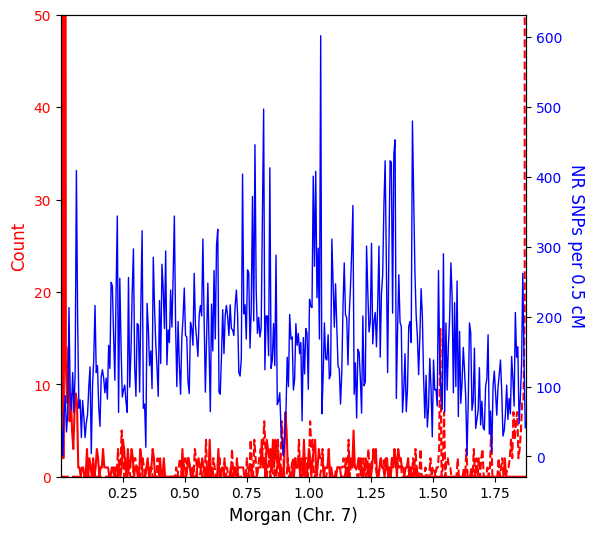

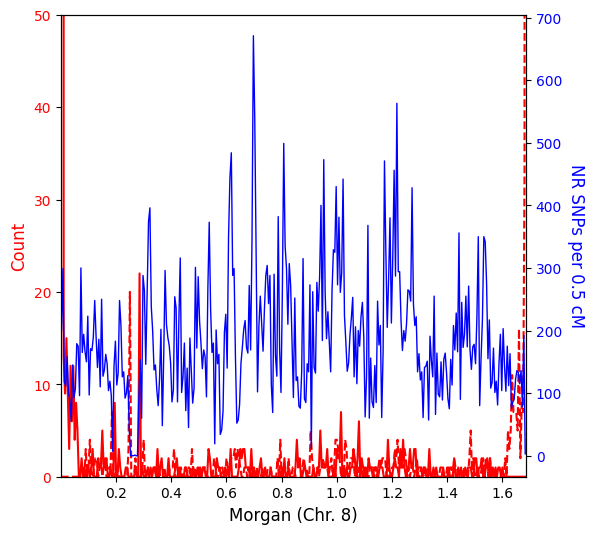

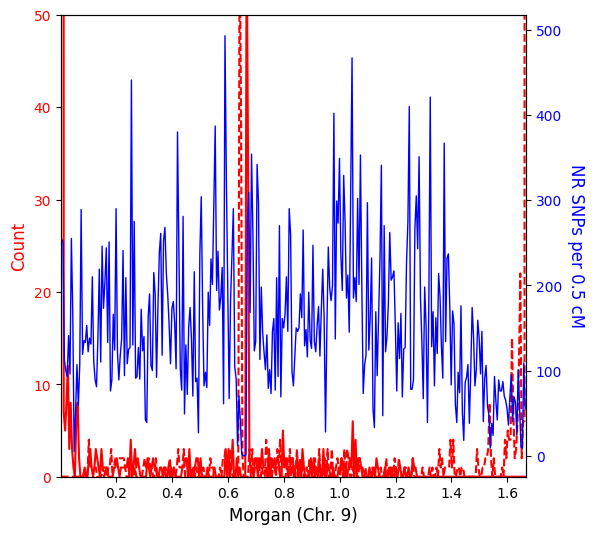

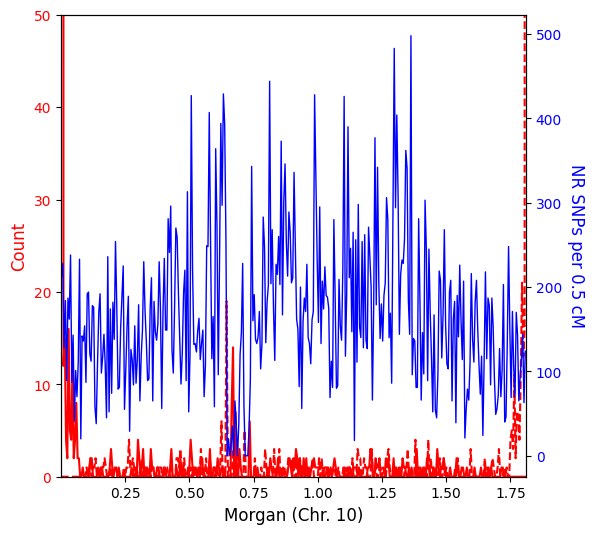

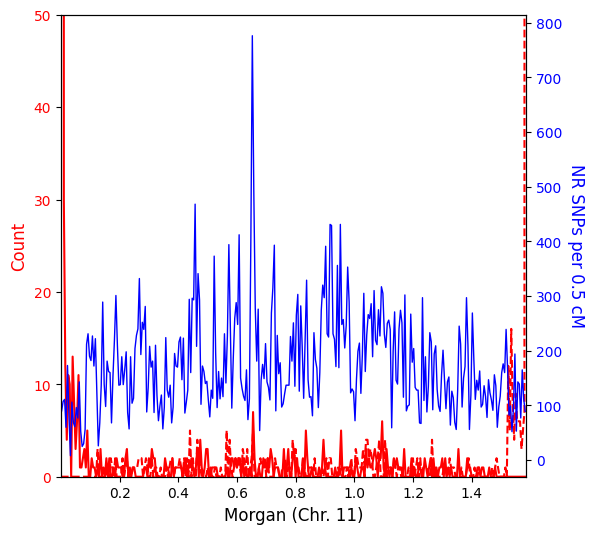

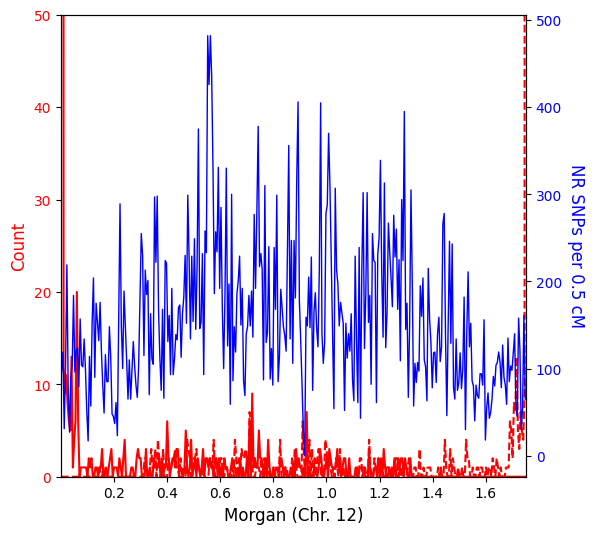

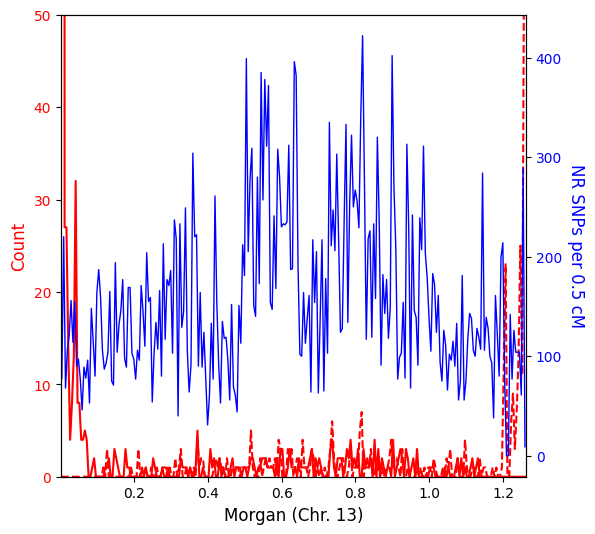

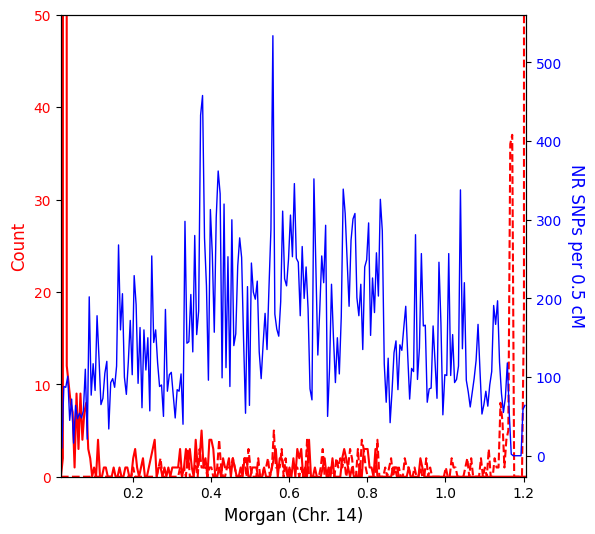

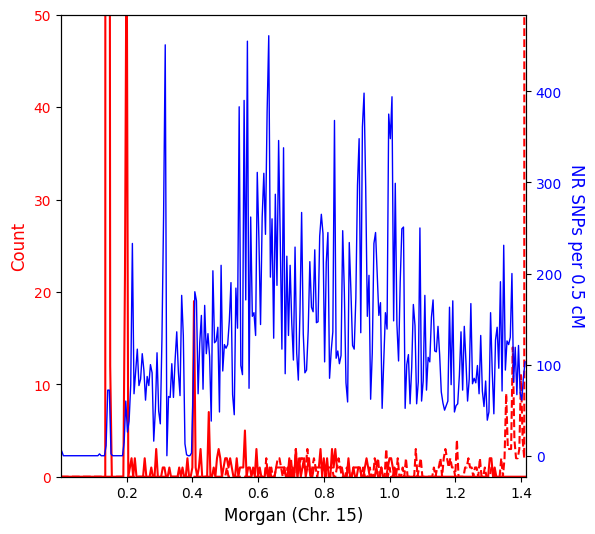

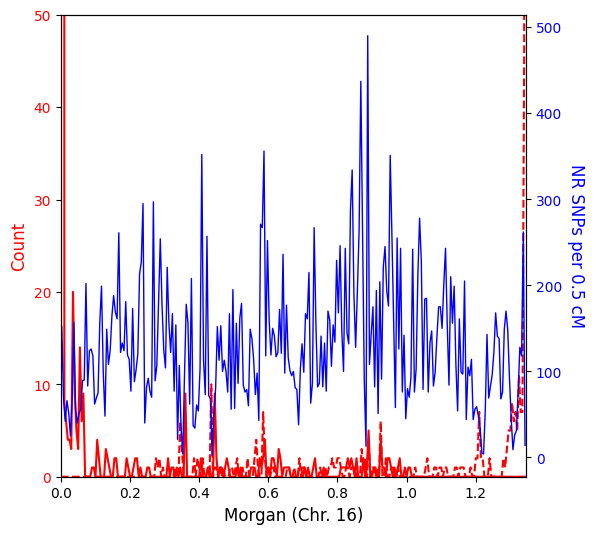

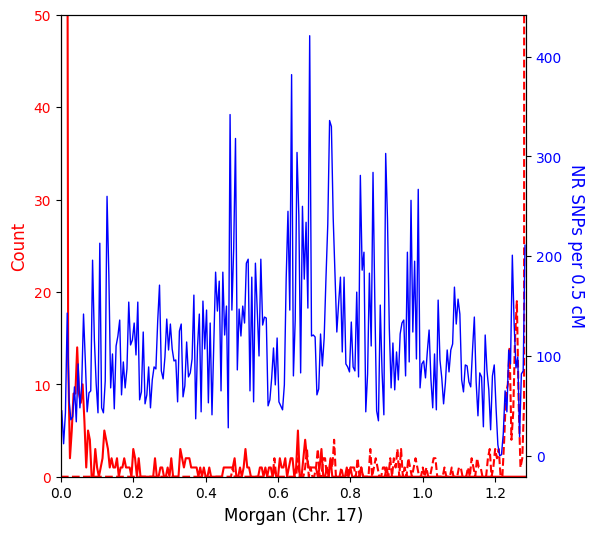

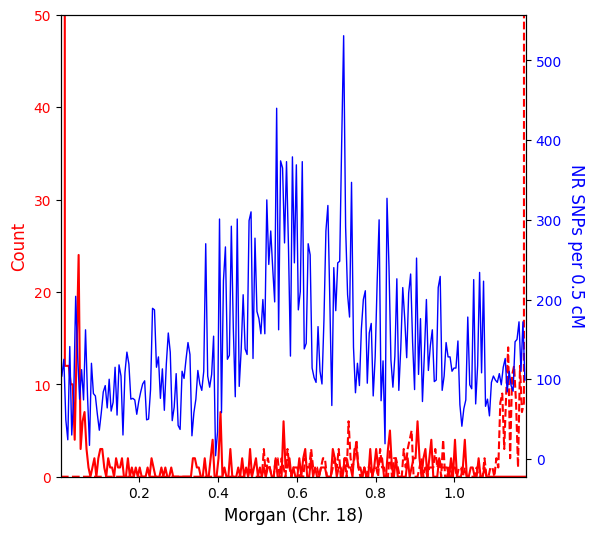

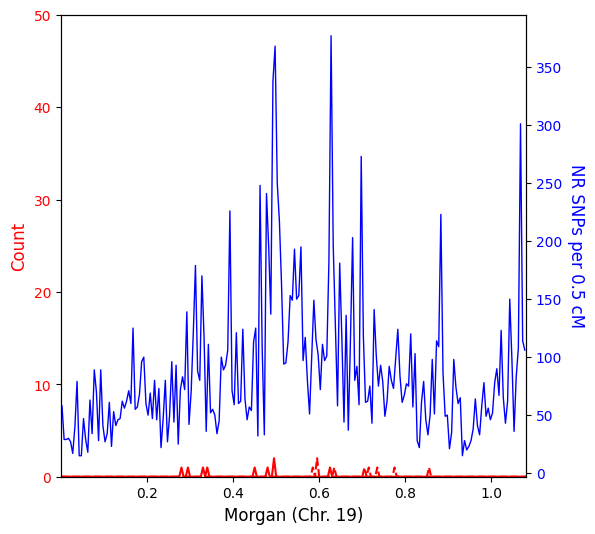

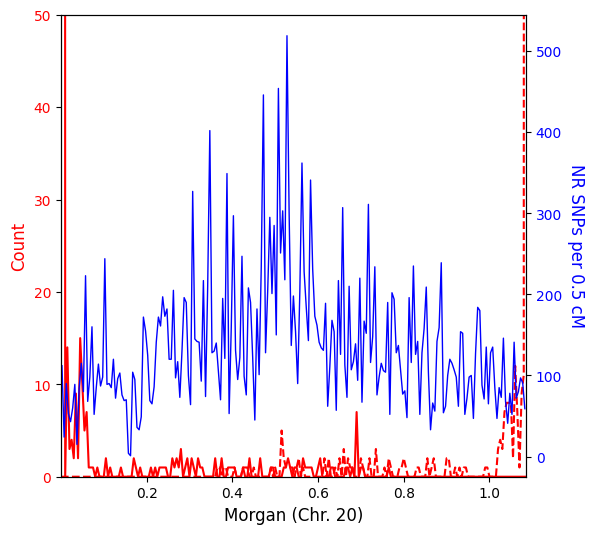

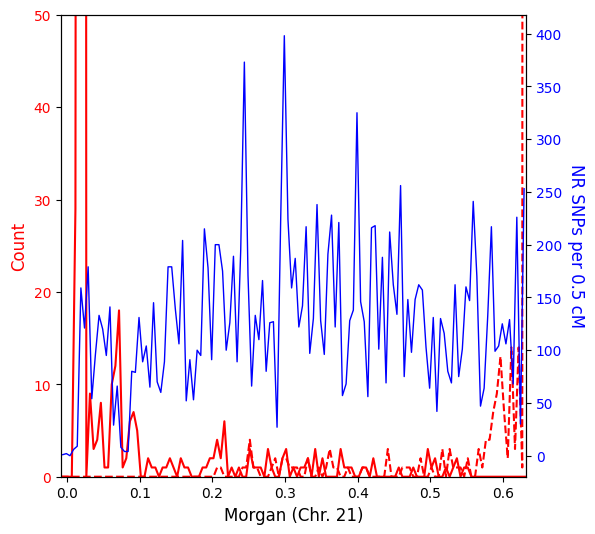

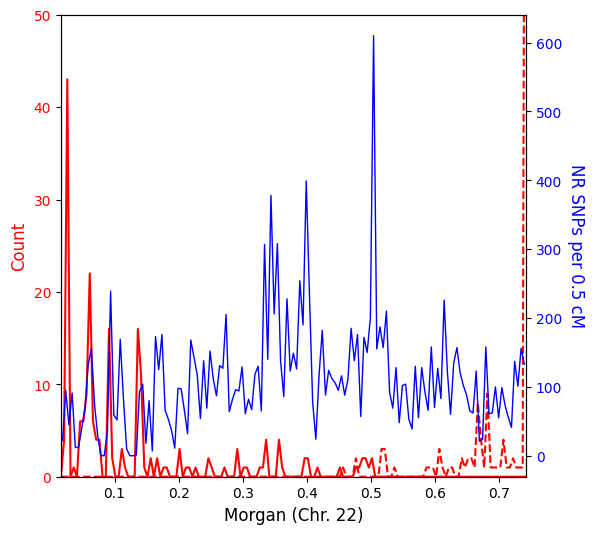

In [13]:
for ch in range(1,23):
    plot_ch_po_rate(bins10_chs[ch-1], counts=counts_chs_start[ch-1], counts_end=counts_chs_end[ch-1],
                    m=ms[ch-1], ch=ch, ylim=[0,50])

# Save the summary statistics of breaking up along genome
Combine each Chromosome.
Save the #IBD segments in bins as well as start and end rate

In [55]:
n_po = len(df_po)
frac_critical = 0.2 # If >80% IBD are missing -> critical region

df_chs = []
for ch in range(1,23):
    dft = pd.DataFrame({"binM": bins10_chs[ch-1][:-1], 
                 "countsStart": counts_chs_start[ch-1][:-1],
                 "countsEnd": counts_chs_end[ch-1][:-1],
                 "#po_ibd": counts_chs[ch-1]})
    dft["ch"]=ch
    dft["break_chance"] = (dft["countsStart"] + dft["countsEnd"]) / (2 * dft["#po_ibd"])
    df_chs.append(dft)
    
df_all = pd.concat(df_chs)

### Flag critical regions that are undercalled 
df_all["critical"] = False
idx = df_all["#po_ibd"]< 0.2 * n_po
df_all.loc[idx,"critical"]=True

In [68]:
df_all

,binM,countsStart,countsEnd,#po_ibd,ch,break_chance,critical
0,0.020130,0,0,0,1,NaN,True
1,0.025130,160,0,160,1,0.500000,True
2,0.030130,1311,0,1471,1,0.445615,False
3,0.035130,20,0,1491,1,0.006707,False
4,0.040130,7,0,1498,1,0.002336,False
...,...,...,...,...,...,...,...
140,0.716324,0,1,143,22,0.003497,True
141,0.721324,0,2,141,22,0.007092,True
142,0.726324,0,1,140,22,0.003571,True
143,0.731324,0,1,139,22,0.003597,True


In [42]:
#df_all[df_all["#po_ibd"]<10]

In [60]:
df_all[df_all["break_chance"].isna()]#["critical"].all()

,binM,countsStart,countsEnd,#po_ibd,ch,break_chance,critical
0,0.020130,0,0,0,1,NaN,True
0,0.000138,0,0,0,2,NaN,True
0,0.000024,0,0,0,3,NaN,True
0,0.003413,0,0,0,4,NaN,True
0,0.000381,0,0,0,5,NaN,True
...,...,...,...,...,...,...,...
0,-0.008529,0,0,0,21,NaN,True
1,-0.003529,0,0,0,21,NaN,True
2,0.001471,0,0,0,21,NaN,True
3,0.006471,0,0,0,21,NaN,True


In [83]:
savepath = "/mnt/archgen/users/hringbauer/git/hapBLOCK/output/countsPO_IBD.tsv"
df_all.to_csv(savepath, sep="\t", index=False)
print(f"Saved binned gap data to: \n{savepath}")

Saved binned gap data to: 
/mnt/archgen/users/hringbauer/git/hapBLOCK/output/countsPO_IBD.tsv


### Simulate the gaps now in `./process_pedsim.ipynb`

In [3]:
df = pd.read_csv("/mnt/archgen/users/hringbauer/git/hapBLOCK/output/countsPO_IBD.tsv", sep="\t")

In [5]:
df

,binM,countsStart,countsEnd,#po_ibd,ch,break_chance,critical
0,0.02013,0,0,0,1,NaN,True
1,0.02513,160,0,160,1,0.500000,True
2,0.03013,1311,0,1471,1,0.445615,False
3,0.03513,20,0,1491,1,0.006707,False
4,0.04013,7,0,1498,1,0.002336,False
5,0.04513,5,0,1503,1,0.001663,False
6,0.05013,4,0,1507,1,0.001327,False
7,0.05513,56,0,1563,1,0.017914,False
8,0.06013,5,0,1568,1,0.001594,False
9,0.06513,8,0,1576,1,0.002538,False


In [6]:
df["ch"].value_counts()

ch
1     569
2     538
3     447
4     429
5     409
6     384
7     375
10    362
12    350
8     337
9     333
11    317
15    283
16    269
17    257
13    252
14    238
18    236
20    217
19    216
22    145
21    128
Name: count, dtype: int64

# Area51

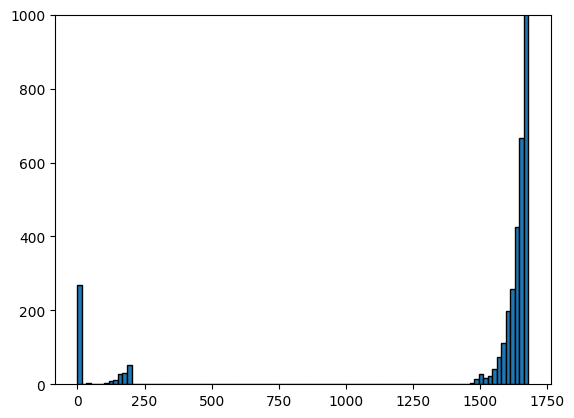

In [51]:
plt.figure()
ax=plt.gca()
ax.hist(df_all["#po_ibd"], edgecolor="k", bins=100)
ax.set_ylim([0,1000])
#ax.set_xlim([0,250])
plt.show()

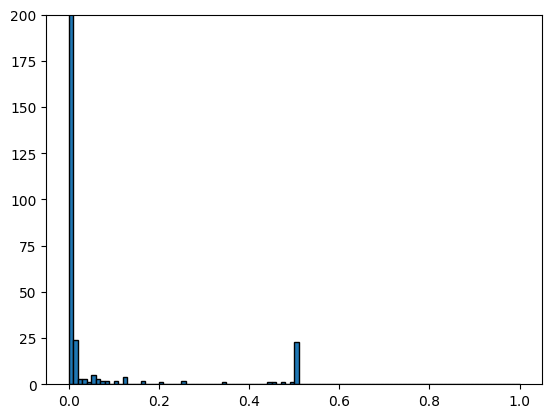

In [77]:
plt.figure()
ax=plt.gca()
ax.hist(df_all["break_chance"], edgecolor="k", bins=np.linspace(0,1,101))
ax.set_ylim([0,200])
#ax.set_xlim([0,250])
plt.show()

In [67]:
np.sum(df_all["countsEnd"])

np.int64(7096)

In [70]:
dfx = df_all[df_all["critical"]==False]

In [81]:
np.sum(dfx["break_chance"]) # The overall expected number of breaks in PO

np.float64(14.787716567963738)

In [82]:
dfx

,binM,countsStart,countsEnd,#po_ibd,ch,break_chance,critical
2,0.030130,1311,0,1471,1,0.445615,False
3,0.035130,20,0,1491,1,0.006707,False
4,0.040130,7,0,1498,1,0.002336,False
5,0.045130,5,0,1503,1,0.001663,False
6,0.050130,4,0,1507,1,0.001327,False
...,...,...,...,...,...,...,...
123,0.606471,0,2,1621,21,0.000617,False
124,0.611471,0,14,1607,21,0.004356,False
125,0.616471,0,3,1604,21,0.000935,False
126,0.621471,0,14,1590,21,0.004403,False


In [80]:
np.sum(dfx["countsStart"]+ dfx["countsEnd"])

np.int64(44689)